In [86]:
from libemg import streamers, data_handler, filtering, gui, emg_predictor, feature_extractor, utils
import os
import json
import time
from os import walk

import numpy as np
from libemg.offline_metrics import OfflineMetrics

In [87]:
WINDOW_SIZE = 200 # 40
WINDOW_INC = 20
CLASSES = [0, 1, 2 , 3, 4]
REPS = [0, 1, 2, 3, 4 , 5]
STAGE = 4 # 0: collect data, 1: prepare model, 2: test band, 3: test model, 4: prepare imu model, 5: prepare imu imu ppg model


In [88]:
def standardize_features(feature_dict):
    """
    Standardise les features après extraction.
    
    Args:
    - feature_dict (dict): Dictionnaire contenant les features à standardiser
    
    Returns:
    - dict: Dictionnaire avec les features standardisées
    """
    standardized_dict = {
        'training_features': {},
        'training_labels': feature_dict['training_labels']
    }
    
    for feature_name, feature_array in feature_dict['training_features'].items():
        # Standardisation (z-score) de chaque colonne de feature
        if feature_array.ndim > 1:
            mean = np.mean(feature_array, axis=0)
            std = np.std(feature_array, axis=0)
            standardized_array = (feature_array - mean) / std
        else:
            mean = np.mean(feature_array)
            std = np.std(feature_array)
            standardized_array = (feature_array - mean) / std
            
        standardized_dict['training_features'][feature_name] = standardized_array
        
    return standardized_dict

In [89]:
def verify_standardize(features, feature_names):
    """
    Vérifie si les features sont déjà standardisées après filtrage.
    
    Args:
    - features (dict): Dictionnaire contenant les différents types de features
    - feature_names (list): Liste des noms de features à vérifier
    """
    print("Vérification de la standardisation des features :")
    for feature_name in feature_names:
        feature_array = features['training_features'][feature_name]
        
        # Statistiques pour chaque dimension du feature array
        if feature_array.ndim > 1:
            for i in range(feature_array.shape[1]):
                print(f"{feature_name} - Dimension {i}:")
                print(f"  Moyenne  : {np.mean(feature_array[:, i]):.4f}")
                print(f"  Écart-type: {np.std(feature_array[:, i]):.4f}")
        else:
            print(f"{feature_name}:")
            print(f"  Moyenne  : {np.mean(feature_array):.4f}")
            print(f"  Écart-type: {np.std(feature_array):.4f}")
        print()

#

In [90]:
import numpy as np

def reshape_and_filter_imu(windows_data, filter_object):
    """
    Reshape and filter IMU data to handle 3D data structure.
    
    Args:
        windows_data (np.ndarray): Data windows with shape (n_windows, n_channels, window_size)
        filter_object (filtering.Filter): Initialized filter object with installed filters
    
    Returns:
        np.ndarray: Filtered data with same shape as input
    """
    n_windows, n_channels, window_size = windows_data.shape
    
    # Option 1: Reshape to 2D, filter, then reshape back to 3D
    reshaped_data = windows_data.reshape(-1, window_size)  # Combine windows and channels
    filtered_data = filter_object.filter(reshaped_data)
    return filtered_data.reshape(n_windows, n_channels, window_size)
    
    # Alternative Option 2: Filter each channel separately
    # filtered_data = np.zeros_like(windows_data)
    # for i in range(n_windows):
    #     for j in range(n_channels):
    #         filtered_data[i, j, :] = filter_object.filter(windows_data[i, j, :].reshape(1, -1))
    # return filtered_data


# Code complet pour traitement IMU
def process_imu_data(folder_location, imu_regex_filters, WINDOW_SIZE, WINDOW_INC):
    odh = data_handler.OfflineDataHandler()
    odh.get_data(folder_location=folder_location, regex_filters=imu_regex_filters)
    windows, metadata = odh.parse_windows(WINDOW_SIZE, WINDOW_INC)
    print("windows shape:", windows.shape)
    print("metadata classes shape:", metadata['classes'].shape)
    
    # Créer et configurer les filtres
    fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
    fi_imu.install_filters({"name": "standardize", "data": odh})
    fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})
    
    # Filtrer les données après reshaping
    filtered_windows = reshape_and_filter_imu(windows, fi_imu)
    print("filtered_windows shape:", filtered_windows.shape)
    
    # Extraction des caractéristiques
    fe = feature_extractor.FeatureExtractor()
    feature_dic = {
        'training_features': fe.extract_features(["WLPHASOR", "DFTR", "WENG", "RMSPHASOR"], filtered_windows),
        'training_labels': metadata['classes']
    }
    
    # Standardisation des caractéristiques
    standardized_feature_dic = standardize_features(feature_dic)
    
    print("Features extraites et standardisées:")
    for feature_name, feature_array in standardized_feature_dic['training_features'].items():
        print(f"  {feature_name} shape: {feature_array.shape}")
        
    return standardized_feature_dic, metadata

# Fonction de standardisation des features (comme définie précédemment)
def standardize_features(feature_dict):
    """
    Standardise les features après extraction.
    
    Args:
    - feature_dict (dict): Dictionnaire contenant les features à standardiser
    
    Returns:
    - dict: Dictionnaire avec les features standardisées
    """
    standardized_dict = {
        'training_features': {},
        'training_labels': feature_dict['training_labels']
    }
    
    for feature_name, feature_array in feature_dict['training_features'].items():
        # Standardisation (z-score) de chaque colonne de feature
        if feature_array.ndim > 1:
            mean = np.mean(feature_array, axis=0)
            std = np.std(feature_array, axis=0)
            # Éviter la division par zéro
            std[std == 0] = 1
            standardized_array = (feature_array - mean) / std
        else:
            mean = np.mean(feature_array)
            std = np.std(feature_array)
            if std == 0:
                std = 1
            standardized_array = (feature_array - mean) / std
            
        standardized_dict['training_features'][feature_name] = standardized_array
        
    return standardized_dict

In [91]:
import os
from pathlib import Path

# Get current notebook directory
CURRENT_DIR = Path(os.path.abspath(''))

# Setup data paths - go up one level from streams to f1 folder
folder_location_0 = str(CURRENT_DIR.parent / "data" / f"S{0}")
folder_location_1 = str(CURRENT_DIR.parent / "data" / f"S{1}") 
folder_location_2 = str(CURRENT_DIR.parent / "data" / f"S{2}")
folder_location_3 = str(CURRENT_DIR.parent / "data" / f"S{3}")
folder_location_4 = str(CURRENT_DIR.parent / "data" / f"S{4}")

# Print path to verify
print(f"Loading data from: {folder_location_0}")
emg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_emg.csv", values = [str(i) for i in CLASSES], description='classes')

    ]
imu_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_imu.csv", values = [str(i) for i in CLASSES], description='classes')
    ]
ppg_regex_filters = [
        data_handler.RegexFilter(left_bound = "C_", right_bound="_R_", values = [str(i) for i in REPS], description='reps'),
        data_handler.RegexFilter(left_bound = "_R_", right_bound="_ppg.csv", values = [str(i) for i in CLASSES], description='classes')
    ]


Loading data from: c:\Users\gueid\Documents\Club IA\F1-team-1\f1\data\S0


In [92]:
odh = data_handler.OfflineDataHandler()
odh

In [94]:

odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_0, regex_filters=imu_regex_filters)
windows_0, metadata_0 = odh.parse_windows(WINDOW_SIZE, WINDOW_INC)
print("windows shape:", windows_0.shape)
print("metadata classes shape:", metadata_0['classes'].shape)

# Créer et configurer les filtres
fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
fi_imu.install_filters({"name": "standardize", "data": odh})
fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})


filtered_windows_0 = reshape_and_filter_imu(windows_0, fi_imu)
print("filtered_windows shape:", filtered_windows_0.shape)

# Extraction des caractéristiques
fe = feature_extractor.FeatureExtractor()
feature_dic = {
    'training_features': fe.extract_features(["WLPHASOR", "DFTR", "WENG", "RMSPHASOR"], filtered_windows_0),
    'training_labels': metadata_0['classes']
}

# Standardisation des caractéristiques
standardized_feature_dic_0 = standardize_features(feature_dic)


print("feature_dic_0", standardized_feature_dic_0)
print("feature_dic_0 WLPHASOR", standardized_feature_dic_0['training_features']['WLPHASOR'].shape)
print("feature_dic_0 DFTR", standardized_feature_dic_0['training_features']['DFTR'].shape)
print("feature_dic_0 WENG", standardized_feature_dic_0['training_features']['WENG'].shape)
print("feature_dic_0 RMSPHASOR", standardized_feature_dic_0['training_features']['RMSPHASOR'].shape)

    

25 data files fetched out of 150 files.
windows shape: (400, 7, 200)
metadata classes shape: (400,)


ValueError: operands could not be broadcast together with shapes (2800,200) (7,) 

In [48]:
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_1, regex_filters=imu_regex_filters)
windows_1, metadata_1 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
#print("windows_1", windows_1)
print("windows_1 shape", windows_1.shape)
# print("metadata_1 classes", metadata_1['classes'])
# print("metadata_1 reps", metadata_1['reps'])
print("metadata_1 classes shape", metadata_1['classes'].shape)
fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})
fi_imu.install_filters({"name": "standardization"})
# 2. Filter the RAW DATA
filtered_windows_1 = fi_imu.filter(windows_1)
#print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_1 shape", filtered_windows_1.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_1 = {
    'training_features': fe.extract_features(["WLPHASOR" , "DFTR" , "WENG" ,"RMSPHASOR"], filtered_windows_1),  # <-- Use filtered_windows
    'training_labels': metadata_1['classes']
}
print("feature_dic_1", feature_dic_1)
print("feature_dic_1 WLPHASOR", feature_dic_1['training_features']['WLPHASOR'].shape)
print("feature_dic_1 DFTR", feature_dic_1['training_features']['DFTR'].shape)
print("feature_dic_1 WENG", feature_dic_1['training_features']['WENG'].shape)
print("feature_dic_1 RMSPHASOR", feature_dic_1['training_features']['RMSPHASOR'].shape)


25 data files fetched out of 150 files.
windows_1 shape (404, 7, 200)
metadata_1 classes shape (404,)
filtered_windows_1 shape (404, 7, 200)
feature_dic_1 {'training_features': {'WLPHASOR': array([[3.07007271, 2.75500894, 2.07794914, ..., 1.35656241, 1.33545822,
        1.34384107],
       [2.52526358, 2.28265978, 1.55534734, ..., 1.19689099, 1.35261203,
        1.29427809],
       [2.6969314 , 2.35888405, 1.62139764, ..., 1.16830375, 1.30399759,
        1.25091626],
       ...,
       [1.37910093, 1.6806737 , 1.35559739, ..., 1.15748878, 1.2209568 ,
        1.17067224],
       [1.2277721 , 1.54554752, 1.21593212, ..., 1.17433301, 1.29201841,
        1.19050412],
       [1.80522532, 2.22746795, 1.7635005 , ..., 1.23053037, 1.38300303,
        1.03718427]]), 'DFTR': array([[0.1199091 , 0.36819724, 0.094198  , ..., 0.01132611, 0.01675164,
        0.01673074],
       [0.11430954, 0.35606208, 0.07184402, ..., 0.01127268, 0.01673502,
        0.016754  ],
       [0.11483451, 0.36039534, 0.07

In [49]:
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_2, regex_filters=imu_regex_filters)
windows_2, metadata_2 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
#print("windows_1", windows_1)
print("windows_2 shape", windows_2.shape)
# print("metadata_1 classes", metadata_1['classes'])
# print("metadata_1 reps", metadata_1['reps'])
print("metadata_2 classes shape", metadata_2['classes'].shape)
fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})
fi_imu.install_filters({"name": "standardization"})
# 2. Filter the RAW DATA
filtered_windows_2 = fi_imu.filter(windows_2)
#print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_2 shape", filtered_windows_2.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_2 = {
    'training_features': fe.extract_features(["WLPHASOR" , "DFTR" , "WENG" ,"RMSPHASOR"], filtered_windows_2),  # <-- Use filtered_windows
    'training_labels': metadata_2['classes']
}
print("feature_dic_2", feature_dic_2)
print("feature_dic_2 WLPHASOR", feature_dic_2['training_features']['WLPHASOR'].shape)
print("feature_dic_2 DFTR", feature_dic_2['training_features']['DFTR'].shape)
print("feature_dic_2 WENG", feature_dic_2['training_features']['WENG'].shape)
print("feature_dic_2 RMSPHASOR", feature_dic_2['training_features']['RMSPHASOR'].shape)

25 data files fetched out of 150 files.
windows_2 shape (402, 7, 200)
metadata_2 classes shape (402,)
filtered_windows_2 shape (402, 7, 200)
feature_dic_2 {'training_features': {'WLPHASOR': array([[2.02203957, 2.24351945, 1.65553386, ..., 0.39352042, 0.98821066,
        0.54576585],
       [1.75718597, 1.810903  , 0.82757737, ..., 0.41499737, 0.91583152,
        0.56339817],
       [1.82517421, 1.8715868 , 0.98454307, ..., 0.40322394, 0.71037457,
        0.49394947],
       ...,
       [2.00005706, 2.47677252, 1.8075094 , ..., 0.14208912, 0.29508447,
        0.10550368],
       [1.90826724, 2.33393168, 1.6374965 , ..., 0.14614437, 0.24054919,
        0.11318614],
       [2.3363133 , 3.09535288, 2.18422142, ..., 0.21452467, 0.30846921,
        0.18659909]]), 'DFTR': array([[0.25575081, 0.30738792, 0.08534033, ..., 0.01303814, 0.01426333,
        0.01806436],
       [0.25592666, 0.30681697, 0.08780694, ..., 0.01301799, 0.01425088,
        0.01808248],
       [0.25595137, 0.30753345, 0.08

In [50]:
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_3, regex_filters=imu_regex_filters)
windows_3, metadata_3 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
#print("windows_1", windows_1)
print("windows_3 shape", windows_3.shape)
# print("metadata_1 classes", metadata_1['classes'])
# print("metadata_1 reps", metadata_1['reps'])
print("metadata_3 classes shape", metadata_3['classes'].shape)
fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})
fi_imu.install_filters({"name": "standardization"})
# 2. Filter the RAW DATA
filtered_windows_3 = fi_imu.filter(windows_3)
#print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_3 shape", filtered_windows_3.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_3 = {
    'training_features': fe.extract_features(["WLPHASOR" , "DFTR" , "WENG" ,"RMSPHASOR"], filtered_windows_3),  # <-- Use filtered_windows
    'training_labels': metadata_3['classes']
}
print("feature_dic_3", feature_dic_3)
print("feature_dic_3 WLPHASOR", feature_dic_3['training_features']['WLPHASOR'].shape)
print("feature_dic_3 DFTR", feature_dic_3['training_features']['DFTR'].shape)
print("feature_dic_3 WENG", feature_dic_3['training_features']['WENG'].shape)
print("feature_dic_3 RMSPHASOR", feature_dic_3['training_features']['RMSPHASOR'].shape)


25 data files fetched out of 150 files.
windows_3 shape (400, 7, 200)
metadata_3 classes shape (400,)
filtered_windows_3 shape (400, 7, 200)
feature_dic_3 {'training_features': {'WLPHASOR': array([[1.49140459, 1.91266161, 1.1628391 , ..., 0.9725025 , 1.43176631,
        1.30081786],
       [0.98742964, 1.40596453, 0.55798082, ..., 1.37641938, 1.73715746,
        1.69825703],
       [1.11088638, 1.54184878, 0.73128071, ..., 1.3635866 , 1.57380391,
        1.57644013],
       ...,
       [1.7804587 , 1.41362606, 0.85931679, ..., 0.3588256 , 0.51393948,
        0.29447809],
       [1.65062668, 1.29390448, 0.7226904 , ..., 0.3768719 , 0.51043845,
        0.32476   ],
       [2.08106249, 1.7607785 , 1.20792967, ..., 0.41132493, 0.49352002,
        0.37533696]]), 'DFTR': array([[0.23967549, 0.318912  , 0.04073216, ..., 0.01575199, 0.01214189,
        0.01597931],
       [0.23943711, 0.31904186, 0.04077942, ..., 0.01574213, 0.01212885,
        0.01600491],
       [0.23904838, 0.31924926, 0.04

In [51]:
odh = data_handler.OfflineDataHandler()
odh.get_data(folder_location=folder_location_4, regex_filters=imu_regex_filters)
windows_4, metadata_4 = odh.parse_windows(WINDOW_SIZE,WINDOW_INC)
#print("windows_1", windows_1)
print("windows_4 shape", windows_4.shape)
# print("metadata_1 classes", metadata_1['classes'])
# print("metadata_1 reps", metadata_1['reps'])
print("metadata_4 classes shape", metadata_4['classes'].shape)
fi_imu = filtering.Filter(100)  # Fréquence d'échantillonnage IMU
fi_imu.install_filters({"name": "lowpass", "cutoff": 20, "order": 4})
fi_imu.install_filters({"name": "standardization"})
# 2. Filter the RAW DATA
filtered_windows_4 = fi_imu.filter(windows_4)
#print("filtered_windows_1", filtered_windows_1)
print("filtered_windows_4 shape", filtered_windows_4.shape)
fe = feature_extractor.FeatureExtractor()
feature_dic_4 = {
    'training_features': fe.extract_features(["WLPHASOR" , "DFTR" , "WENG" ,"RMSPHASOR"], filtered_windows_4),  # <-- Use filtered_windows
    'training_labels': metadata_4['classes']
}
print("feature_dic_4", feature_dic_4)
print("feature_dic_4 WLPHASOR", feature_dic_4['training_features']['WLPHASOR'].shape)
print("feature_dic_4 DFTR", feature_dic_4['training_features']['DFTR'].shape)
print("feature_dic_4 WENG", feature_dic_4['training_features']['WENG'].shape)
print("feature_dic_4 RMSPHASOR", feature_dic_4['training_features']['RMSPHASOR'].shape)


25 data files fetched out of 150 files.
windows_4 shape (400, 7, 200)
metadata_4 classes shape (400,)
filtered_windows_4 shape (400, 7, 200)
feature_dic_4 {'training_features': {'WLPHASOR': array([[2.57256159, 2.64645937, 3.73014664, ..., 0.96410747, 0.96991058,
        0.96577218],
       [2.02582431, 2.21424799, 2.64495282, ..., 0.96218472, 0.96599304,
        0.94748448],
       [2.17056186, 2.34992818, 3.15756464, ..., 0.96188021, 0.97073999,
        0.96205416],
       ...,
       [1.7629086 , 2.11129353, 1.74017724, ..., 1.09731131, 1.178499  ,
        0.99941307],
       [1.63243666, 2.03227966, 1.6606177 , ..., 1.03012858, 1.08747332,
        0.980203  ],
       [2.30425757, 2.54950214, 2.13698384, ..., 0.97704729, 1.03107127,
        0.95219   ]]), 'DFTR': array([[0.25977244, 0.30642596, 0.08692829, ..., 0.01622385, 0.01606985,
        0.01444815],
       [0.25995371, 0.3068818 , 0.08838532, ..., 0.0062204 , 0.0053769 ,
        0.00500436],
       [0.26013707, 0.30756241, 0.08

In [52]:
filtered_windows = np.concatenate(( filtered_windows_0,filtered_windows_1,filtered_windows_2,filtered_windows_3))
print("filtered_windows shape", filtered_windows.shape)
print("filtered_windows", filtered_windows)

filtered_windows shape (1606, 7, 200)
filtered_windows [[[ 3.51045492  3.48294897  3.54528649 ...  4.17371131  4.22639381
    4.2623061 ]
  [-7.04345877 -7.29495465 -7.07098748 ... -7.09995308 -6.95386684
   -6.69280527]
  [ 8.86607251  8.78356572  8.63516611 ...  6.08350987  5.97932244
    5.65952076]
  ...
  [ 0.4032844   0.61814492  0.74094614 ...  0.74144144  0.7398332
    0.6260194 ]
  [ 0.63176209  0.43502587  0.17383365 ...  0.14138552 -0.14735917
   -0.42033037]
  [-0.31398116 -0.07068036  0.18288599 ...  0.2174594   0.43556803
    0.59203894]]

 [[ 3.62309649  3.60210649  3.61547051 ...  4.29717803  4.31860774
    4.35915897]
  [-6.56419181 -6.60050266 -6.62166525 ... -7.36354245 -7.16214661
   -7.02740614]
  [ 7.16387919  7.19202929  7.18380518 ...  5.45646982  5.44438258
    5.33521912]
  ...
  [ 0.04248933 -0.01538641 -0.07152525 ... -0.07664202 -0.11768753
   -0.14364933]
  [-0.14357141 -0.14753746 -0.12980992 ... -0.12306197 -0.08536039
   -0.03351697]
  [ 0.13100582  0.1

In [55]:
["WLPHASOR" , "DFTR" , "WENG" ,"RMSPHASOR"]
feature_dic = {
        'training_features': {},
        'training_labels': None
    }
feature_dic['training_features']["WLPHASOR"] = np.concatenate((
    feature_dic_0['training_features']['WLPHASOR'],
    feature_dic_1['training_features']['WLPHASOR'],
    feature_dic_2['training_features']['WLPHASOR'],
    feature_dic_3['training_features']['WLPHASOR'],
    #feature_dic_4['training_features']['WLPHASOR']
))
print("WLPHASOR features : ", feature_dic['training_features']["WLPHASOR"])
# Concatenate DFTR features
feature_dic['training_features']["DFTR"] = np.concatenate((
    feature_dic_0['training_features']['DFTR'],
    feature_dic_1['training_features']['DFTR'],
    feature_dic_2['training_features']['DFTR'],
    feature_dic_3['training_features']['DFTR'],
    #feature_dic_4['training_features']['DFTR']
))
print("DFTR features : ", feature_dic['training_features']["DFTR"])
# Concatenate WENG features
feature_dic['training_features']["WENG"] = np.concatenate((
    feature_dic_0['training_features']['WENG'],
    feature_dic_1['training_features']['WENG'],
    feature_dic_2['training_features']['WENG'],
    feature_dic_3['training_features']['WENG'],
    #feature_dic_4['training_features']['WENG']
))
print("WENG features : ", feature_dic['training_features']["WENG"])
# Concatenate RMSPHASOR features
feature_dic['training_features']["RMSPHASOR"] = np.concatenate((
    feature_dic_0['training_features']['RMSPHASOR'],
    feature_dic_1['training_features']['RMSPHASOR'],
    feature_dic_2['training_features']['RMSPHASOR'],
    feature_dic_3['training_features']['RMSPHASOR'],
    #feature_dic_4['training_features']['RMSPHASOR']
))
print("RMSPHASOR features : ", feature_dic['training_features']["RMSPHASOR"])


# Concatenate all labels
feature_dic['training_labels'] = np.concatenate((
    feature_dic_0['training_labels'],
    feature_dic_1['training_labels'],
    feature_dic_2['training_labels'],
    feature_dic_3['training_labels'],
    #feature_dic_4['training_labels']
))
print("feature_dic['training_labels'] : ", feature_dic['training_labels'])



WLPHASOR features :  [[2.96059908 3.05290155 3.62395231 ... 0.96059342 0.95770593 0.97672258]
 [2.32400684 2.55578222 2.33851659 ... 0.95876334 0.96776294 0.95542413]
 [2.44685291 2.61607079 2.98533881 ... 0.96089228 0.9598083  0.97659741]
 ...
 [1.7804587  1.41362606 0.85931679 ... 0.3588256  0.51393948 0.29447809]
 [1.65062668 1.29390448 0.7226904  ... 0.3768719  0.51043845 0.32476   ]
 [2.08106249 1.7607785  1.20792967 ... 0.41132493 0.49352002 0.37533696]]
DFTR features :  [[0.1951478  0.289799   0.31499369 ... 0.01321674 0.01675173 0.01533   ]
 [0.19876357 0.28695808 0.27665957 ... 0.00562852 0.00495215 0.00518316]
 [0.20148768 0.28639983 0.25579619 ... 0.0083403  0.01040932 0.00966179]
 ...
 [0.28456417 0.04424511 0.29758809 ... 0.0107431  0.00719179 0.01958876]
 [0.28463682 0.0418264  0.29778103 ... 0.01074277 0.00718522 0.01958934]
 [0.28497816 0.04259885 0.29818939 ... 0.01074142 0.00717984 0.01958916]]
WENG features :  [[ 10.34272461  11.48423966  11.58063845 ...  -4.25023605

In [56]:
print("Distribution des classes :", np.unique(feature_dic['training_labels'], return_counts=True))

Distribution des classes : (array([0, 1, 2, 3, 4], dtype=int64), array([321, 320, 321, 321, 323], dtype=int64))


In [57]:
model = emg_predictor.EMGClassifier("LDA")
model.fit(feature_dictionary=feature_dic)
model.add_velocity(filtered_windows, feature_dic['training_labels'])
model.add_majority_vote(5)

In [58]:
predictions , probabilities = model.run(test_data=feature_dic_4['training_features'])
print("predictions", predictions)
print("probabilities", probabilities)
np.unique(predictions, return_counts=True)

predictions [1 1 1 1 4 4 4 4 4 4 4 4 4 4 4 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1
 1 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 1 1 1 1 4 4 4 4 4 4 4 0 0 0 0 0 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 3 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 4 4 4 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
probabilities [0.80382472 0.99599904 0.54217188 0.99998154 0.99988014 0.99993026
 0.92634186 0.9998757  0.99905086 0.99999698 0.99998352 0.99980338
 0.67717236 0.85145121 0.994

(array([0, 1, 2, 3, 4]), array([125,  13,   6,   2, 254], dtype=int64))

In [59]:
OfflineMetrics = OfflineMetrics()
OfflineMetrics.extract_common_metrics(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

AER not computed... Please input the null_label parameter.


{'CA': 0.1425, 'INS': 0.0}

In [60]:
OfflineMetrics.get_CONF_MAT(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

array([[17.,  4.,  4.,  0., 55.],
       [16.,  0.,  2.,  0., 62.],
       [16.,  9.,  0.,  0., 55.],
       [38.,  0.,  0.,  0., 42.],
       [38.,  0.,  0.,  2., 40.]])

In [61]:
OfflineMetrics.get_RECALL(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

0.14250000000000002

In [62]:
OfflineMetrics.get_PREC(y_true=feature_dic_4['training_labels'], y_predictions=predictions)

0.058696062992125986

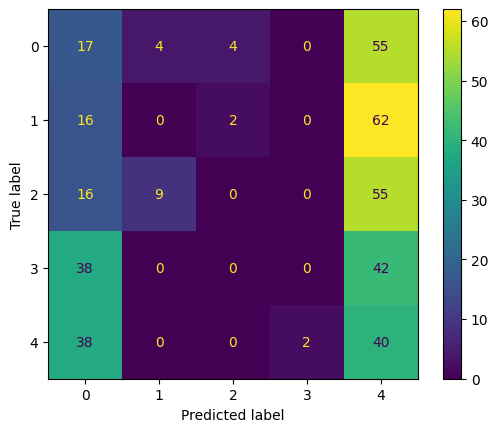

In [63]:
OfflineMetrics.visualize_conf_matrix(OfflineMetrics.get_CONF_MAT(y_true=feature_dic_4['training_labels'], y_predictions=predictions))